In [ ]:
"""
Project 2 - RBP-RNA Interaction Prediction
"""
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import hyperopt as hp
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
"""
Training against ELAV1 dataset.
"""
a = open('CLIPSEQ_ELAVL1.train.positives.fasta')
b = open('CLIPSEQ_ELAVL1.train.negatives.fasta')
c = open('CLIPSEQ_ELAVL1.test.positives.fasta')
d = open('CLIPSEQ_ELAVL1.test.negatives.fasta')


TempTrainData=[]
TempTrainLabel=[]
TempTestData=[]
TempTestLabel=[]

for line in a:
  if line[0]!='>':
    TempTrainLabel.append(1)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTrainData.append(tmp)

for line in b:
  if line[0]!='>':
    TempTrainLabel.append(0)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTrainData.append(tmp)

for line in c:
  if line[0]!='>':
    TempTestLabel.append(1)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTestData.append(tmp)

for line in d:
  if line[0]!='>':
    TempTestLabel.append(0)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTestData.append(tmp)

trainData = np.array(TempTrainData)           
trainLabel = np.array(TempTrainLabel)
testData = np.array(TempTestData)
testLabel = np.array(TempTestLabel)

trainData = np.expand_dims(trainData, axis=-1)
testData = np.expand_dims(testData, axis=-1)

In [ ]:
print(type(trainData),type(trainLabel),type(testData),type(testLabel))
print(trainData.shape, trainLabel.shape, testData.shape, testLabel.shape)

In [ ]:
"""
Tuning neural network hyperparameters with HyperOpt Library.
"""

hyperparameters = {'conv_layers': [2,3,4],
                   'conv_filters': [32,64,128],
                   'dense_layers': [1,2,3],
                   'conv_dropout': [None, 0.15],
                   'dense_dropout': [None, 0.1, 0.25],
                   'dense_units': [32,64,128],
                   'filter_depth': [4,6,10,12]}
space={'conv_layers':hp.hp.choice('conv_layers', [2,3,4]),
       'conv_filters':hp.hp.choice('conv_filters', [32,64,128]),
       'dense_layers':hp.hp.choice('dense_layers', [1,2,3]),
       'conv_dropout':hp.hp.choice('conv_dropout', [None, 0.15]),
       'dense_dropout':hp.hp.choice('dense_dropout', [None, 0.1, 0.25]),
       'dense_units':hp.hp.choice('dense_units', [32,64,128]),
       'filter_depth':hp.hp.choice('filter_depth', [4,6,10,12])}



In [ ]:
"""
Function outputing new models with given hyperparameters.
"""

def create_model(params):
  model = models.Sequential()
  model.add(layers.Conv2D(params['conv_filters'],(params['filter_depth'],4), activation = 'relu', input_shape = (200,4,1)))
  if params['conv_dropout']:
    model.add(layers.Dropout(rate=params['conv_dropout']))
  for i in range(params['conv_layers']-1):
    model.add(layers.Conv2D(params['conv_filters'],(params['filter_depth'],1), activation = 'relu'))
    if params['conv_dropout']:
      model.add(layers.Dropout(rate=params['conv_dropout']))
  model.add(layers.Flatten())
  for i in range(params['dense_layers']):
    model.add(layers.Dense(params['dense_units'], activation='relu'))
    if params['dense_dropout']:
      model.add(layers.Dropout(params['dense_dropout']))
  model.add(layers.Dense(1))

  model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
  return model

In [ ]:
"""
Training function.
"""
def fitting_params(params):
    model = create_model(params)
    
    global k
    print("\nSearch Iteration: %d" % k)
    k+=1
    print("Testing parameters: ", end='')
    print(params)

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 1, verbose =0, mode = 'auto')
    history = tf.keras.callbacks.History()
    model.fit(trainData, trainLabel, callbacks=[earlyStopping, history], batch_size=32, epochs=50, verbose=2, validation_split=0.2)
    return{'loss':earlyStopping.best, 'status': hp.STATUS_OK}

In [ ]:
model = create_model({'conv_layers': 2,
                   'conv_filters': 128,
                   'dense_layers': 2,
                   'conv_dropout': 0.15,
                   'dense_dropout': 0.1,
                   'filter_depth': 10,
                   'dense_units': 64})

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 191, 1, 128)       5248      
_________________________________________________________________
dropout (Dropout)            (None, 191, 1, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 182, 1, 128)       163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 182, 1, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 23296)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1491008   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
"""
Testing 70 different sets of hyperparameters.
"""
k = 0
trials = hp.Trials()
best = hp.fmin(fitting_params, space, algo = hp.tpe.suggest, max_evals = 70, trials = trials)
print('best: {', end='')
print('conv_dropout:', hyperparameters['conv_dropout'][best['conv_dropout']],
      ', conv_filters:', hyperparameters['conv_filters'][best['conv_filters']],
      ', conv_layers:', hyperparameters['conv_layers'][best['conv_layers']],
      ', dense_dropout:', hyperparameters['dense_dropout'][best['dense_dropout']],
      ', dense_layers:', hyperparameters['dense_layers'][best['dense_layers']],
      ', filter_depth:', hyperparameters['filter_depth'][best['filter_depth']],
      ', dense_units:', hyperparameters['dense_units'][best['dense_units']], '}')


Search Iteration: 0
Testing parameters: 
{'conv_dropout': 0.15, 'conv_filters': 64, 'conv_layers': 4, 'dense_dropout': None, 'dense_layers': 3, 'dense_units': 128, 'filter_depth': 12}
Epoch 1/50
414/414 - 5s - loss: 0.1023 - accuracy: 0.8776 - val_loss: 0.0572 - val_accuracy: 0.9151

Epoch 2/50
414/414 - 4s - loss: 0.0600 - accuracy: 0.9281 - val_loss: 0.0491 - val_accuracy: 0.9341

Epoch 3/50
414/414 - 4s - loss: 0.0548 - accuracy: 0.9316 - val_loss: 0.1036 - val_accuracy: 0.8686


Search Iteration: 1
Testing parameters: 
{'conv_dropout': 0.15, 'conv_filters': 128, 'conv_layers': 2, 'dense_dropout': None, 'dense_layers': 3, 'dense_units': 64, 'filter_depth': 12}
Epoch 1/50
414/414 - 4s - loss: 0.0800 - accuracy: 0.9074 - val_loss: 0.0718 - val_accuracy: 0.8846

Epoch 2/50
414/414 - 4s - loss: 0.0512 - accuracy: 0.9381 - val_loss: 0.0446 - val_accuracy: 0.9444

Epoch 3/50
414/414 - 4s - loss: 0.0424 - accuracy: 0.9494 - val_loss: 0.0398 - val_accuracy: 0.9372

Epoch 4/50
414/414 - 4s 

In [ ]:
"""
Evaluating the predicted best set of hyperparameters against test dataset.
Accuracy and ROC=AUC are calculated.
Accuracy was approximately 0.93.
"""
model = create_model({'conv_layers': 2,
                   'conv_filters': 128,
                   'dense_layers': 2,
                   'conv_dropout': 0.15,
                   'dense_dropout': 0.1,
                   'filter_depth': 10,
                   'dense_units': 64})
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 1, verbose =0, mode = 'auto')
model.fit(trainData, trainLabel, callbacks=earlyStopping, batch_size=32, epochs=50, verbose=0, validation_split=0.2)

testLoss, testAcc = model.evaluate(testData, testLabel, verbose=1)

prediction= np.squeeze(model.predict_on_batch(testData))
fpr, tpr, thresholds = roc_curve(testLabel, prediction)
print("\nHighest Accuracy: %f\nHighest AUC: %f" % (testAcc, auc(fpr, tpr)))

31/31 [==============================] - 0s 6ms/step - loss: 0.0560 - accuracy: 0.9282

Highest Accuracy: 0.928205
Highest AUC: 0.979485


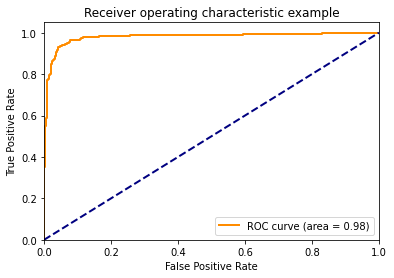

In [ ]:
"""
Drawing ROC curve.
"""
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
"""
Exploring RBP-binding motif sequences based on the colvolution layer weights.
"""
filterNo=128
filterDepth=10

motif=[]
for j in range(filterNo):
  a=model.layers[0].get_weights()[0][:,:,:,j]
  tmpmotif=''
  for i in range(filterDepth):
    if np.argmax(a, axis=1)[i][0]==0:
      tmpmotif=tmpmotif+'A'
    if np.argmax(a, axis=1)[i][0]==1:
      tmpmotif=tmpmotif+'U'
    if np.argmax(a, axis=1)[i][0]==2:
      tmpmotif=tmpmotif+'C'
    if np.argmax(a, axis=1)[i][0]==3:
      tmpmotif=tmpmotif+'G'
  motif.append(tmpmotif)
print(motif)

['UCCUUUCCUA', 'UAAUCUACAC', 'CCCUUUUUUU', 'CGCGCAUAGU', 'CCACGGGUCA', 'GUCUAUACGG', 'GCCCUGGUAG', 'CUCCGUGAGA', 'ACUCGUAGCU', 'AUACAUGCUC', 'UGUGUCAUGG', 'UUUACAGACU', 'CCUCGGUAAA', 'UUGUUCCAAG', 'GGAACUGACG', 'CCAAGACAUG', 'GCAAGUCCCG', 'AGUCGGGUAA', 'ACCAUUUACU', 'GAUUUUUAUU', 'UUGUCCUACC', 'CAUCUUUUUU', 'UUUUUACCGC', 'ACCCACCUCA', 'CUAUAUUCCG', 'UAGGGGGGGG', 'ACCAGAACCU', 'AGUGGAGGCC', 'GGCAUCAGAU', 'AGGGGGAAUG', 'GCUGGAGCGC', 'AAGAGAGAGA', 'GAAGGAGCCG', 'ACUUAUCUCU', 'CCUUAGAUUG', 'CUCUAACCAU', 'AACAGGGAUU', 'GGCCGAGCCC', 'CCACUAACUU', 'AACCUAUACU', 'GGGUCCCGCC', 'AGUAGGCUCA', 'UCUCAAGUGG', 'CACCUUUGUG', 'CUCCUCUUCG', 'AGCAUGCCAG', 'GGCAUGCAAA', 'CGAGGAUGGC', 'GCGGAAAGAG', 'AGGGGCGGCG', 'AUUUUAUUUU', 'AUCAACACCU', 'CACCGGUUAA', 'AUCGUGAGGG', 'ACUAAGGUUG', 'GUUCCUGGAG', 'AGUUAUCAUU', 'UUUGUUAGAG', 'UAAUAACUCA', 'CGUCCUAGAC', 'GGGGAUUCCA', 'CAUACAUCUC', 'ACAACGUCCC', 'GGGCACUGGG', 'UUUGGUUUGU', 'CCUGAGGCUG', 'UACGAAUGAA', 'GCGCAAUAUU', 'CCGAGGGCAG', 'UGUGCUAAUC', 'CAUCUUUUAA', 'UGCA

In [ ]:
"""
Same procedure is again performed with ALKBH5 dataset.
"""

a = open('ALKBH5_Baltz2012.train.positives.fasta')
b = open('ALKBH5_Baltz2012.train.negatives.fasta')
c = open('ALKBH5_Baltz2012.test.positives.fasta')
d = open('ALKBH5_Baltz2012.test_negatives.fasta')


TempTrainData=[]
TempTrainLabel=[]
TempTestData=[]
TempTestLabel=[]

for line in a:
  if line[0]!='>':
    TempTrainLabel.append(1)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTrainData.append(tmp)

for line in b:
  if line[0]!='>':
    TempTrainLabel.append(0)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTrainData.append(tmp)

for line in c:
  if line[0]!='>':
    TempTestLabel.append(1)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTestData.append(tmp)

for line in d:
  if line[0]!='>':
    TempTestLabel.append(0)
    tmp=[]
    for i in line:
        if i=='a' or i=='A':
          tmp.append([1,0,0,0])
        if i=='u' or i=='U' or i=='t' or i=='T':
          tmp.append([0,1,0,0])
        if i=='c' or i=='C':
          tmp.append([0,0,1,0])
        if i=='g' or i=='G':
          tmp.append([0,0,0,1])
    TempTestData.append(tmp)

trainData = np.array(TempTrainData)           
trainLabel = np.array(TempTrainLabel)
testData = np.array(TempTestData)
testLabel = np.array(TempTestLabel)

trainData = np.expand_dims(trainData, axis=-1) 
testData = np.expand_dims(testData, axis=-1)    

print(type(trainData),type(trainLabel),type(testData),type(testLabel))
print(trainData.shape, trainLabel.shape, testData.shape, testLabel.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2361, 200, 4, 1) (2361,) (262, 200, 4, 1) (262,)


In [ ]:
"""
Low accuracy of ~0.6 was recorded, probably due to low number of instances.
"""
model = create_model({'conv_layers': 2,
                   'conv_filters': 128,
                   'dense_layers': 2,
                   'conv_dropout': 0.15,
                   'dense_dropout': 0.1,
                   'filter_depth': 10,
                   'dense_units': 64})
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 1, verbose =0, mode = 'auto')
model.fit(trainData, trainLabel, callbacks=earlyStopping, batch_size=32, epochs=50, verbose=0, validation_split=0.2)

testLoss, testAcc = model.evaluate(testData, testLabel, verbose=1)

prediction= np.squeeze(model.predict_on_batch(testData))
fpr, tpr, thresholds = roc_curve(testLabel, prediction)
print("\nHighest Accuracy: %f\nHighest AUC: %f" % (testAcc, auc(fpr, tpr)))

9/9 [==============================] - 0s 4ms/step - loss: 0.2399 - accuracy: 0.5496

Highest Accuracy: 0.549618
Highest AUC: 0.622808


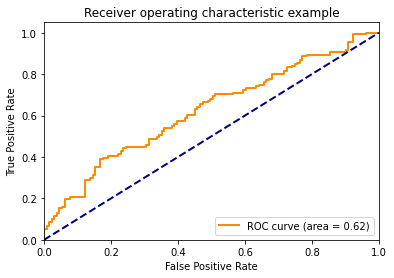

In [ ]:
"""
Drawing ROC curve.
"""
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
"""
Exploring RBP-binding motif sequences based on the colvolution layer weights.
"""
filterNo=128
filterDepth=10

motif=[]
for j in range(filterNo):
  a=model.layers[0].get_weights()[0][:,:,:,j]
  tmpmotif=''
  for i in range(filterDepth):
    if np.argmax(a, axis=1)[i][0]==0:
      tmpmotif=tmpmotif+'A'
    if np.argmax(a, axis=1)[i][0]==1:
      tmpmotif=tmpmotif+'U'
    if np.argmax(a, axis=1)[i][0]==2:
      tmpmotif=tmpmotif+'C'
    if np.argmax(a, axis=1)[i][0]==3:
      tmpmotif=tmpmotif+'G'
  motif.append(tmpmotif)
print(motif)

['CUUUAACUCG', 'UGUUCCUCUC', 'AAUUAAAGUG', 'CCUUUUGAUG', 'CCAUAUACGG', 'CUUAACCCGU', 'CAUUGGCGGU', 'UGUUUCCCAC', 'GCGAACACCU', 'AAUCCGGUUC', 'CAAUGCUUAU', 'AUUGCUCGUU', 'ACCAGACAAU', 'UUGCCGUCGG', 'UUUCUCAUGC', 'UGUAUGACCU', 'UGCCAACGGG', 'GUCAACGAUG', 'AUGAAGAGCA', 'ACAAGGAGGA', 'CUGGCACUCC', 'GCAUUGCAGG', 'GGAGGUCAUU', 'GCUAAUGCCC', 'AGAAUAGCUC', 'AUCAGCUAAU', 'ACAGCAGCAA', 'AGUGCCCUUG', 'GCGCCCCUUU', 'CAGGAGUUAC', 'GGACGUUUUA', 'UCGUGUAGUG', 'UUGCGUACUU', 'UUUCCCUAUC', 'CGCUCAACGG', 'CCAUGACUCU', 'GCACCGAAGA', 'GGCCUCCUGC', 'GCUCGUGCCG', 'AGCAAACAGC', 'CGAGUCUUCC', 'UUAUUAACGC', 'UAAUCGCGCA', 'AGUUAGGCCU', 'GAAGAAUCUG', 'GAGACAUACU', 'CGCGUAUUUU', 'ACUGCUCAUC', 'UGUUGAUUAU', 'AAACGGAUCA', 'UGGAAACAAU', 'UCCGCUACAU', 'CUGAGAAGCC', 'GCUAAAUGCA', 'GAGCCCUGGU', 'UCCUGCGUCU', 'AGUAUUUAUG', 'UAUAGUCUGU', 'CUUUUAAACC', 'CUUGCAGGCC', 'GGGUAGGGGC', 'UGACCCUGCA', 'UCUGCGUCGU', 'GUCGUCAUUU', 'UCCGUGGGGC', 'GUGAUGUAGG', 'CCAUCGAGGA', 'CUACGGGAAA', 'CUGGACAACG', 'GGCUCGUUUG', 'UCGACGACGU', 'GACA